In [67]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from pylab import rcParams
from sklearn.model_selection import LeaveOneOut, KFold
import statsmodels.api as sm
from scipy.interpolate import LSQUnivariateSpline


import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')


wine = pd.read_csv('data/strongdrink.txt')


In [6]:
wine = wine[['cultivar', 'alco', 'malic', 'tot_phen', 'color_int']]
wine.head()

,cultivar,alco,malic,tot_phen,color_int
0,1,14.23,1.71,2.80,5.64
1,1,13.20,1.78,2.65,4.38
2,1,13.16,2.36,2.80,5.68
3,1,14.37,1.95,3.85,7.80
4,1,13.24,2.59,2.80,4.32


In [16]:
wine.isnull().sum()

cultivar     0
alco         0
malic        0
tot_phen     0
color_int    0
dtype: int64

In [17]:
wine.cultivar.value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

In [19]:
X = wine[['alco', 'malic', 'tot_phen', 'color_int']]
y = wine[['cultivar']]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.25, random_state=20)
MultLogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
MultLogReg.fit(X_train, y_train)
y_pred = MultLogReg.predict(X_test)
print(MultLogReg.intercept_)
print(MultLogReg.coef_)
print(MultLogReg.classes_)
print(classification_report(y_test, y_pred))

[-24.01127085  22.80207642   1.20919443]
[[ 1.70042655 -0.26560788  1.2238949   0.02275118]
 [-1.46801561 -0.3330518   0.66400736 -0.92271036]
 [-0.23241108  0.59865968 -1.88790227  0.89995911]]
[1 2 3]
             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44



/Users/liruixue/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
print('Validation set MSE = ', mean_squared_error(y_test, y_pred))

Validation set MSE =  0.045454545454545456


In [27]:
Xvars = X.values
yvals = y.values

In [35]:
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE_vec = np.zeros(N_loo)

for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_vec[test_index] = (y_test - y_pred) ** 2
    #print(classification_report(y_test, y_pred))
    #print('MSE for test set', test_index, ' is', MSE_vec[test_index])

MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('test estimate MSE loocv=', MSE_loo,
      ', test estimate MSE standard err=', MSE_loo_std)

/Users/liruixue/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test estimate MSE loocv= 0.09659090909090909 , test estimate MSE standard err= 0.39426250589387657


In [39]:
k = 3
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(Xvars)

MSE_vec_kf = np.zeros(k)

k_ind = int(0)
for train_index, test_index in kf.split(Xvars):
    # print("TRAIN:", train_index, "TEST:", test_index)
    print('k index=', k_ind)
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_vec_kf[k_ind] = ((y_test - y_pred) ** 2).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate MSE standard err=', MSE_kf_std)

k index= 0


/Users/liruixue/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE for test set 0  is 1.0879057742028153
k index= 1
MSE for test set 1  is 1.262855501292732
k index= 2
MSE for test set 2  is 1.095719381688466
test estimate MSE k-fold= 1.1488268857280046 test estimate MSE standard err= 0.08069348173258804


In [58]:
cool = pd.read_csv('data/CoolIndex.txt', names = ['age', 'coolness'])

In [59]:
cool.head()

,age,coolness
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


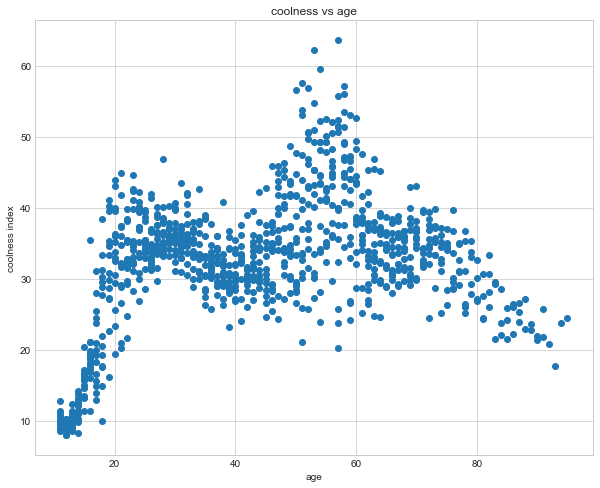

In [60]:
plt.scatter(cool.age, cool.coolness)
plt.xlabel('age')
plt.ylabel('coolness index')
plt.title('coolness vs age')
plt.show()

In [62]:
age = cool['age']
age_bin1 = ((age >= 11) & (age < 22)).astype(int)
age_bin2 = ((age >= 22) & (age < 40)).astype(int)
age_bin3 = ((age >= 40) & (age < 59)).astype(int)
age_bin4 = ((age >= 59) & (age < 77)).astype(int)
age_bin5 = ((age >= 77) & (age <= 95)).astype(int)
X_step = pd.DataFrame(dict(age_bin1=age_bin1, age_bin2=age_bin2,
                           age_bin3=age_bin3, age_bin4=age_bin4,
                           age_bin5=age_bin5))
X_step.head()


,age_bin1,age_bin2,age_bin3,age_bin4,age_bin5
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [63]:
reg = sm.OLS(endog=cool['coolness'], exog=X_step, missing='drop')
reg_results = reg.fit()
y_pred = reg_results.predict(X_step)
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:               coolness   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Sun, 18 Feb 2018   Prob (F-statistic):          3.73e-114
Time:                        14:37:50   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_bin1      20.1025      0.562     35.746      0.0

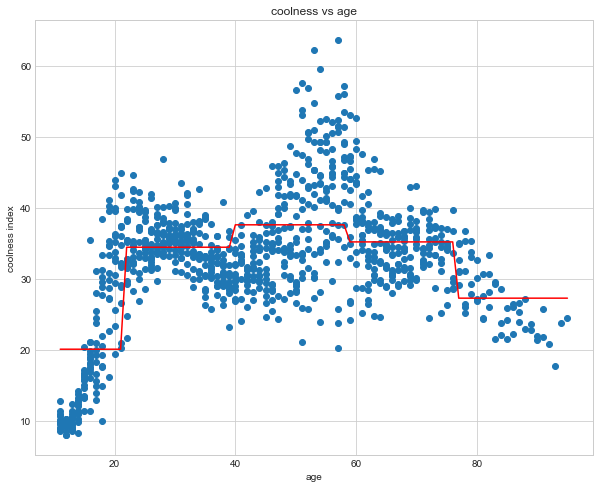

In [74]:
plt.scatter(cool.age, cool.coolness)
plt.plot(cool.age, y_pred, color = 'r')
plt.xlabel('age')
plt.ylabel('coolness index')
plt.title('coolness vs age')
plt.show()

In [75]:
t = [22, 40, 59, 77]
spl_cubic = LSQUnivariateSpline(cool.age, cool.coolness, t, k=1)
#y_pred = spl_cubic(cool.age)

ValueError: x must be strictly increasing

In [73]:
spl_cubic = LSQUnivariateSpline(cool.age, cool.coolness, t, k=3)
#y_pred = spl_cubic(cool.age)

ValueError: x must be strictly increasing

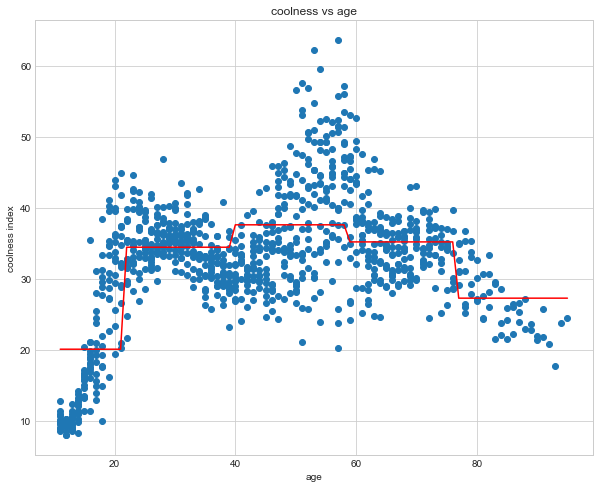

In [72]:
plt.scatter(cool.age, cool.coolness)
plt.plot(cool.age, y_pred, color = 'r')
plt.xlabel('age')
plt.ylabel('coolness index')
plt.title('coolness vs age')
plt.show()